<a href="https://colab.research.google.com/github/aschelin/SimulacoesAGFE/blob/main/Aula_de_SC_EDPparte02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Equação de Burguer

> Este tutorial é baseado no material "[CFD Python: 12 steps to Navier-Stokes](https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/)" de Lorena A. Barba. 


Agora vamos resolver a [equação de Burguer](http://en.wikipedia.org/wiki/Burgers'_equation) em 1D:


$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial ^2u}{\partial x^2}$$

Podemos ver que ela é uma combinação da equação de convecção e de difusão. 

Podemos discretizá-la usando os métodos que já detalhamos.  Usando a diferença para frente para o tempo, a diferença para trás para o espaço e o método de segunda ordem para o termo da segunda derivada temos:

$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + u_i^n \frac{u_i^n - u_{i-1}^n}{\Delta x} = \nu \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}$$

Como antes, uma vez que a condição inicial é dada, a única incógnita é $u_i^{n+1}$. O próximo passo no tempo será então:

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$





### Condições iniciais e de contorno

Para examinar algumas propriedades interessantes da equação de Burgers, é útil usar condições iniciais e de contorno diferentes das que temos usado nas etapas anteriores.  

Nossa condição inicial para este problema vai ser:

\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-x^2}{4 \nu} \bigg) + \exp \bigg(\frac{-(x-2 \pi)^2}{4 \nu} \bigg)
\end{eqnarray}

Existe uma solução analítica, dada por:

\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-(x-4t)^2}{4 \nu (t+1)} \bigg) + \exp \bigg(\frac{-(x-4t -2 \pi)^2}{4 \nu(t+1)} \bigg)
\end{eqnarray}

Nossa condição de contorno será:

$$u(0) = u(2\pi)$$

Essa condição de contorno é chamada de *periódica*. 

### Poupando tempo com a SymPy


A condição inicial que estamos usando para a Equação de Burgers pode ser um pouco chata para escrever à mão.  A derivada parcial $\frac{\partial \phi}{\partial x}$ não é difícil de ser resolvida, mas seria fácil esquecer algum sinal ou um fator de $x$ em algum lugar. Por isso, vamos usar a SymPy para nos ajudar.  

O [SymPy](http://sympy.org/en/) é uma biblioteca matemática simbólica do Python.  Ela tem a mesma funcionalidade matemática simbólica do Mathematica com o benefício adicional de podermos facilmente traduzir seus resultados de volta para nossos cálculos em Python. Ela também é gratuita e de código aberto. 

Comece carregando a biblioteca SymPy, juntamente com nossa biblioteca favorita, o NumPy.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sympy

Também vamos dizer ao SymPy que queremos que toda a sua produção seja renderizada usando $\LaTeX$. Isto tornará nosso Notebook mais bonito!

In [ ]:
from sympy import init_printing
init_printing(use_latex=True)

Comece configurando variáveis simbólicas para as três variáveis em nossa condição inicial e depois digite a equação completa de $\phi$. 

In [ ]:
x, nu, t = sympy.symbols('x nu t')

phi = sympy.exp(-(x-4*t)**2/(4*nu*(t+1))) + sympy.exp(-(x-4*t-2*sympy.pi)**2/(4*nu*(t+1)))

phi

Agora podemos calcular a derivada parcial $\frac{\partial \phi}{\partial x}$:

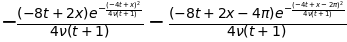

In [ ]:
phiprime = phi.diff(x)

phiprime

Para ver a versão não renderizada, basta escrever *print*:

In [ ]:
print(phiprime)

-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 4*pi)*exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1)))/(4*nu*(t + 1))


Agora que temos a versão Pythonic da nossa derivada, podemos terminar de escrever a equação da condição inicial e depois traduzi-la em uma expressão Python utilizável.   Para isso, usaremos a função *lambdify*, que pega uma equação simbólica SymPy e a transforma em uma função que pode ser chamada.  

In [ ]:
from sympy.utilities.lambdify import lambdify

u = -2 * nu * (phiprime / phi) + 4
print(u)  

-2*nu*(-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 4*pi)*exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)))/(exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1))) + exp(-(-4*t + x)**2/(4*nu*(t + 1)))) + 4


### Lambdify

Para trasfomrmar esta expressão em uma função utilizável, dizemos à lambdify quais variáveis devem ser solicitadas e a função à qual queremos conectá-las.

In [ ]:
ufunc = lambdify((t,x,nu),u)

In [ ]:
print(ufunc(1,4,3))

3.49170664206445


### De volta à Equação de Burgers

Agora que temos as condições iniciais estabelecidas, podemos prosseguir com nosso problema.  Podemos gerar um gráfico das condições iniciais usando nossa função lambdify-ed.

In [ ]:
nx = 101
nt = 100
dx = 2 * np.pi / (nx - 1)

nu = 0.07

dt = dx * nu

x = np.linspace(0,2*np.pi,nx)

un = np.empty(nx)
t = 0

u = np.asarray([ufunc(t,x0,nu) for x0 in x])

u


array([4.        , 4.06283185, 4.12566371, 4.18849556, 4.25132741,
       4.31415927, 4.37699112, 4.43982297, 4.50265482, 4.56548668,
       4.62831853, 4.69115038, 4.75398224, 4.81681409, 4.87964594,
       4.9424778 , 5.00530965, 5.0681415 , 5.13097336, 5.19380521,
       5.25663706, 5.31946891, 5.38230077, 5.44513262, 5.50796447,
       5.57079633, 5.63362818, 5.69646003, 5.75929189, 5.82212374,
       5.88495559, 5.94778745, 6.0106193 , 6.07345115, 6.136283  ,
       6.19911486, 6.26194671, 6.32477856, 6.38761042, 6.45044227,
       6.51327412, 6.57610598, 6.63893783, 6.70176967, 6.76460125,
       6.82742866, 6.89018589, 6.95176632, 6.99367964, 6.72527549,
       4.        , 1.27472451, 1.00632036, 1.04823368, 1.10981411,
       1.17257134, 1.23539875, 1.29823033, 1.36106217, 1.42389402,
       1.48672588, 1.54955773, 1.61238958, 1.67522144, 1.73805329,
       1.80088514, 1.863717  , 1.92654885, 1.9893807 , 2.05221255,
       2.11504441, 2.17787626, 2.24070811, 2.30353997, 2.36637

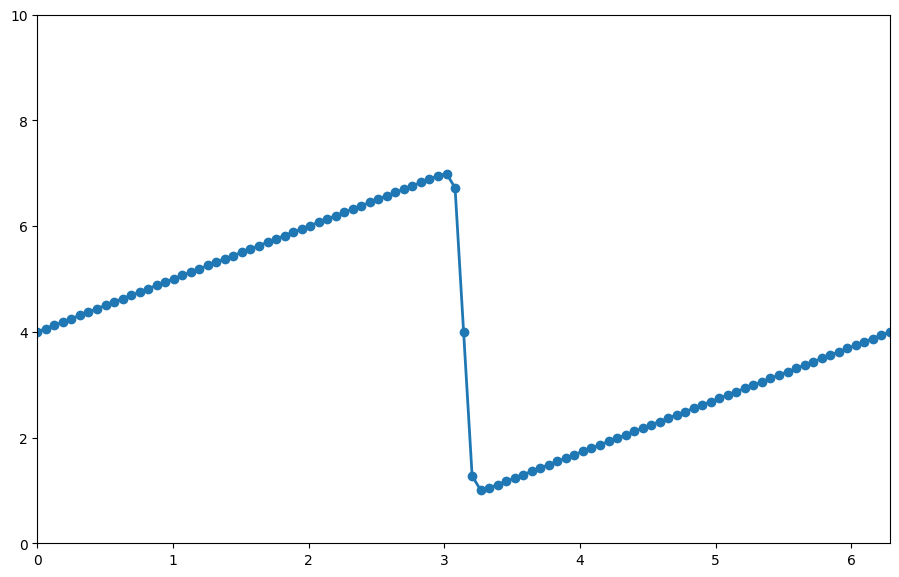

In [ ]:
plt.figure(figsize=(11, 7), dpi=100)
plt.plot(x, u, marker='o', lw=2)
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10]);

Esta não é a função de chapéu com a qual temos lidado até agora. Nós a chamamos de "função serra-dentada".  Vamos prosseguir e ver o que acontece.  

### Condições de contorno periódicas

Uma das grandes novidades em relação aos casos anteriores é o uso de condições de contorno *periódicas*.  Se você simular o tutorial anterior e fizer a simulação funcionar por mais tempo (aumentando o `nt'), você notará que a onda continuará se movendo para a direita até que não apareça mais no gráfico.  

Com condições de contorno periódicas, quando um ponto chega ao lado direito da grade, ele se projeta para a esquerda da grade.  

Lembrem-se da discretização que trabalhamos no início deste notebook:

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

O que fazemos com $u_{i+1}^n$ quando $i$ já está no final da grade?




In [ ]:
for n in range(nt):
  un = u.copy()
  for i in range(1,nx-1):
     u[i] = un[i] - un[i] * dt / dx *(un[i] - un[i-1]) + nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])
     u[0] = un[0] - un[0] * dt / dx * (un[0] - un[-2]) + nu * dt / dx**2 * (un[1] - 2 * un[0] + un[-2])
     u[-1] = u[0]


In [ ]:
u_analytical = np.asarray([ufunc(nt * dt, xi, nu) for xi in x])

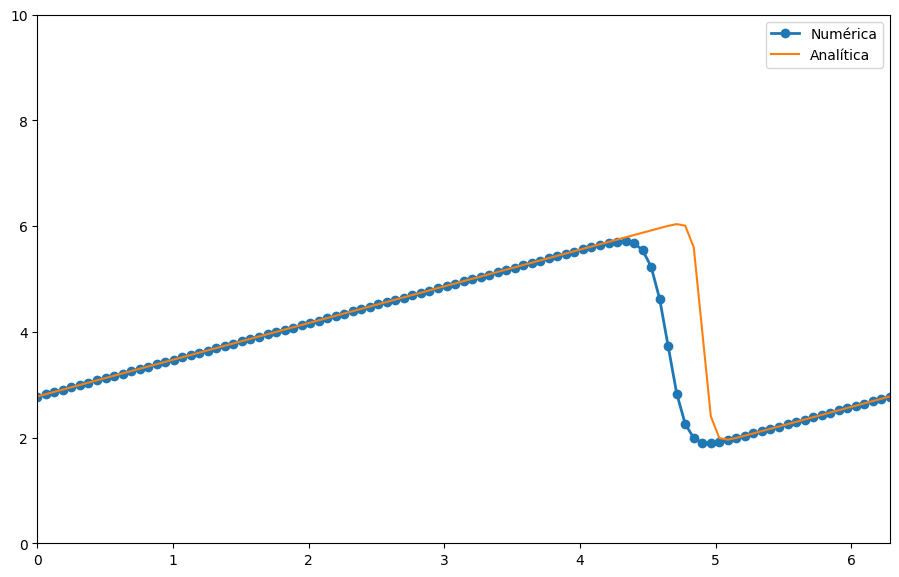

In [ ]:
plt.figure(figsize=(11, 7), dpi=100)
plt.plot(x,u, marker='o', lw=2, label='Numérica')
plt.plot(x, u_analytical, label='Analítica')
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10])
plt.legend();

### Quais serão os próximos passos?

Em seguida, vamos considerar as equações em mais dimensões. A extensão das fórmulas de diferença finita para o caso 2D ou 3D não é difícil, apenas lembre a derivada parcial em relação a $x$ é a variação em $x$ mantendo $y$ constante e vice-versa. 